<a href="https://colab.research.google.com/github/Werdert45/yt-sponsoredby-segmentation/blob/main/_Adolfi(2023)_recreation_code_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###A comparison of Wav2Vec 2.0 and humans in handling frequency shifted speech: A Qualitative Analysis
This Colab notebook presents an analysis of speech manipulations using the Wav2Vec2.0 model and evaluates its performance using evaluation metrics. The research is conducted as part of a bachelor thesis, aiming to investigate the robustness of the model in the presence of various speech manipulations. The notebook demonstrates the tokenization of audio signals and the application of manipulations such as masking and shifting. It feeds the manipulated signals to the model for transcription prediction and calculates evaluation metrics like Word Error Rate (WER) by comparing the predicted transcriptions with a reference. The obtained transcriptions, WER values, and relevant metrics provide insights into the model's accuracy and performance in different speech manipulation scenarios. This work contributes to the understanding of the Wav2Vec2.0 model's applicability in real-world speech processing tasks and serves as a valuable resource for researchers and practitioners in the field of automatic speech recognition.

 Installing and Importing


In [1]:
#Installing datasets & wget
!pip install -q datasets wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.0 MB/s eta 0:00:00


In [2]:
#Installing Transformers
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.7 MB/s eta 0:00:00


In [3]:
#Importing important libraries and Adolfi(2023) available code
import wget
import os
if not os.path.exists('pycochleagram'):
  !git clone https://github.com/mcdermottLab/pycochleagram
  os.chdir('pycochleagram')
  !python setup.py install
if not os.path.exists('manipulations.py'):
  wget.download('https://gitfront.io/r/fedeadolfi/b8d002dbffa6392bbe8d1793e2ea5d66a8e209ac/asr-vs-humans/raw/manipulations.py')
if not os.path.exists('analyses.py'):
  wget.download('https://gitfront.io/r/fedeadolfi/b8d002dbffa6392bbe8d1793e2ea5d66a8e209ac/asr-vs-humans/raw/analyses.py')

Cloning into 'pycochleagram'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 4.62 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (241/241), done.
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

     

In [4]:
from datasets import load_dataset, get_dataset_config_names, get_dataset_split_names
import IPython.display as ipd
from IPython.display import Audio
from manipulations import *
from analyses import *

In [5]:
import soundfile as sf
import librosa
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

Loading LibriSpeech test data

In [6]:
ls_test = load_dataset("librispeech_asr", "clean", split="test", streaming=True)

In [7]:
N_samples = 100
ls_test_subset = list(ls_test.take(N_samples))

In [8]:
def get_signal(ls_item):
  return ls_item['audio']['array']

def get_sr(ls_item):
  return ls_item['audio']['sampling_rate']

In [9]:
# choose audio sample
sample = ls_test_subset[0]
print(type(sample))
signal = get_signal(sample)
sr = get_sr(sample)
sr_ms = sr / 1000
print(type(signal))
print(sr)

<class 'dict'>
<class 'numpy.ndarray'>
16000


In [10]:
Audio(data=signal, rate=sr)

Using the model: Wav2Vec2.0

In [11]:
# Create an instance of the Wav2Vec2Tokenizer class and load the tokenizer from the "facebook/wav2vec2-base-960h" pretrained model
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")

# Create an instance of the Wav2Vec2ForCTC class and load the model from the "facebook/wav2vec2-base-960h" pretrained model
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Tokenize the audio signal using the tokenizer and convert it to PyTorch tensors
input_values = tokenizer(signal, return_tensors="pt").input_values

# Pass the input values through the Wav2Vec2 model to get the logits
logits = model(input_values).logits

# Find the predicted token ids by taking the argmax along the last dimension of the logits
predicted_ids = torch.argmax(logits, dim=-1)

# Decode the predicted token ids into text using the tokenizer and extract the first (and only) sequence
text = tokenizer.batch_decode(predicted_ids)[0]


In [13]:
#Original audio as input
text

'CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS'

Repackaging

In [14]:
#@title Redefined timewarp function
def my_timewarp(signal, stretch_factor):
  hop_len = 512
  n_fft = 1024
  power = None  # if None, the complex spectrogram is returned
  _spectrogram = torchaudio.transforms.Spectrogram(
      n_fft=n_fft,
      win_length=None,
      hop_length=hop_len,
      power=power,
      center=True,
      pad_mode="reflect",
      )
  _timestretch = torchaudio.transforms.TimeStretch(
      hop_length=hop_len, n_freq=513, fixed_rate=stretch_factor  # > 1.0 is compression
      )

  _magnitude = lambda arr: torch.abs(arr)
  ###
  _griffinlim = torchaudio.transforms.GriffinLim(
      n_iter=32,
      n_fft=n_fft,
      win_length=None,
      hop_length=hop_len,
      power=1.0,
      )
  return _griffinlim(_magnitude(_timestretch(_spectrogram((torch.tensor(signal)))))).numpy()

In [15]:
def _compute_segmentation(signal, win_len):
    # Get the remainder of the signal that will be missed by windowing
    num_remainder = signal.shape[-1] % win_len
    signal_remainder = np.array(signal[signal.shape[-1] - num_remainder:])[np.newaxis, :]
    # Get sliding windows of the signal, keep only adjacent non-overlapping windows
    chunks = np.array(
        np.lib.stride_tricks.sliding_window_view(signal, win_len, axis=0)[0::win_len, :]
        )  # shape=(num_chunks, window_shape)
    return chunks, signal_remainder

def _compute_insert(chunks, len_silence):
    # Assumes shape of `chunks` is (num_chunks, len_chunks)
    # returns chunks with silence. Shape = (num_chunks, len_chunks + len_silence)
    return np.concatenate([
        np.append(arr, np.zeros(len_silence))[np.newaxis, :]
        for arr in chunks
        ], axis=0)

def _assemble_sequence(chunks, remainder):
    return np.concatenate([arr for arr in chunks] + [remainder[0, :]], axis=0)

def compress_insert(signal, len_silence, stretch_factor=3.0, win_len=640):
    signal_compressed = my_timewarp(signal, stretch_factor)
    chunks, remainder = _compute_segmentation(signal_compressed, win_len)
    chunks_transf = _compute_insert(chunks, len_silence)
    signal_transf = _assemble_sequence(chunks_transf, remainder)
    return signal_transf

def compress_insert_mix(signal, stretch_factor=3.0, win_len=640, snr=1.0, len_silence=640, src=None):
    return  mix(
        compress_insert(signal=signal, len_silence=len_silence,
                        stretch_factor=stretch_factor, win_len=win_len),
        snr=snr,
        src=src
        )

In [16]:
#Changing the length of silence
len_silence_list = [1280, 1067, 914, 800, 711, 640, 582, 533, 492, 457, 427, 400, 376, 356, 337, 320 ]
#Creating list of manipulated audios
cimed_list = []
#Manipulating audios with different silence length
for length in len_silence_list:
  cimed = compress_insert_mix(signal,
                            stretch_factor= 2.0,
                            win_len=640,
                            snr=1.0,
                            len_silence= length,
                            src=None)
  print(length)
  ipd.display(Audio(data=cimed, rate=sr))
  cimed_list.append(cimed)

1280


1067


914


800


711


640


582


533


492


457


427


400


376


356


337


320


In [17]:
#Feeding manipulations to Wav2Vec2.0
text2_list = []
for s in cimed_list:
  input_values = tokenizer(s,return_tensors="pt").input_values
  logits = model(input_values).logits
  predicted_ids = torch.argmax(logits,dim=-1)
  text_2 = tokenizer.batch_decode(predicted_ids)[0]
  text2_list.append(text_2)
  print(text_2)


OEROR T TE ETE T T TEIT TOTEIIT  TTEMCATT
E ER  IITEST ITST TEGIST  THETTEMEGAEST
ORDWARD TI T TI TE MINUTE THE TE
OETU ST AMIDSTT THE TETT
AR TURNS AMIDST THE DACKERSS
R TI  AIS THE TT
S MIDST THE TAT
REAT
RTURAMIT THE DEAT

E


RETURAM
RETURNEMITHE AT


Analysis

In [18]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.4 MB/s eta 0:00:00


In [19]:
#Calculating Word Eroor Rate for each manipulation
from jiwer import wer

reference = text
error_list = []
for hypothesis in text2_list:
  error = wer(reference, hypothesis)
  print(error)
  error_list.append(error)
  print(error_list)

1.0
[1.0]
1.125
[1.0, 1.125]
1.0
[1.0, 1.125, 1.0]
0.875
[1.0, 1.125, 1.0, 0.875]
0.875
[1.0, 1.125, 1.0, 0.875, 0.875]
0.75
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75]
0.875
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875]
0.875
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875]
1.0
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0]
0.875
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0, 0.875]
1.0
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0, 0.875, 1.0]
1.0
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0, 0.875, 1.0, 1.0]
1.0
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0, 0.875, 1.0, 1.0, 1.0]
1.0
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0]
1.0
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Visualisation

In [20]:
import plotly.express as px

def create_graph(x_values, y_values):
    # Create the plot using Plotly Express
    fig = px.line(x=x_values, y=y_values, markers=True)

    # Customize the plot
    fig.update_layout(
        xaxis_title="Audio:Silence Ratio",
        yaxis_title="WER (Word Error Rate)",
        title="Wav2Vec Word Error Rate",
        legend_title="",
        showlegend=True,
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.5),
        margin=dict(l=50, r=50, t=50, b=50),
    )

    # Show the plot
    fig.show()

# Example data
x_data = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
y_data = error_list

# Call the function to create the graph
create_graph(x_data, y_data)


Masking

In [21]:
# Define a list of window lengths for masking
winlen_list = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Create an empty list to store the masked signals
masked_list = []

# Iterate over each window length in the winlen_list
for length_2 in winlen_list:

    # Mask the original signal using the specified parameters
    masked = mask(signal,
                  win_len=length_2,
                  mask_fraction=0.5,
                  mask="noise",  # "silence" or "noise"
                  snr=0.75,
                  fade_len=0)

    # Display the masked audio signal using IPython's display function
    ipd.display(Audio(data=masked, rate=sr))

    # Append the masked signal to the masked_list
    masked_list.append(masked)

In [22]:
# Create an empty list to store the resulting text after feeding masked signals to Wav2Vec2.0
text3_list = []

# Iterate over each masked signal in the masked_list
for m in masked_list:

    # Tokenize the masked signal using the tokenizer and convert it to PyTorch tensors
    input_values = tokenizer(m, return_tensors="pt").input_values

    # Pass the input values through the Wav2Vec2.0 model to get the logits
    logits = model(input_values).logits

    # Find the predicted token ids by taking the argmax along the last dimension of the logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Decode the predicted token ids into text using the tokenizer and extract the first (and only) sequence
    text_3 = tokenizer.batch_decode(predicted_ids)[0]

    # Append the resulting text to the text3_list
    text3_list.append(text_3)

    # Print the resulting text
    print(text_3)


CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS


analysing

In [23]:
# Import the word error rate (WER) calculation function from the jiwer library
from jiwer import wer

# Set the reference text for comparison
reference = text

# Create an empty list to store the WER for each manipulation
error_list_2 = []

# Iterate over each hypothesis text in text3_list
for hypothesis_2 in text3_list:

    # Calculate the word error rate (WER) between the reference and the hypothesis text
    error_2 = wer(reference, hypothesis_2)

    # Print the calculated WER
    print(error_2)

    # Append the WER to the error_list_2
    error_list_2.append(error_2)

    # Print the current contents of the error_list_2
    print(error_list_2)

0.0
[0.0]
0.0
[0.0, 0.0]
0.0
[0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Visualising (make changes)

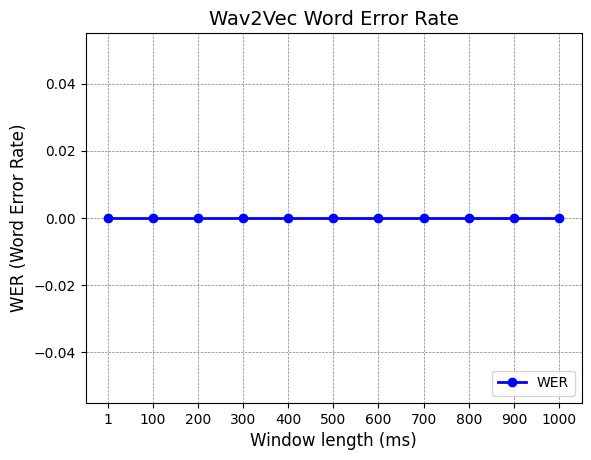

In [24]:
import matplotlib.pyplot as plt

def create_graph(x_values, y_values):
    # Customize the plot
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', linewidth=2)
    plt.xlabel("Window length (ms)", fontsize=12)
    plt.ylabel('WER (Word Error Rate)', fontsize=12)
    plt.title("Wav2Vec Word Error Rate", fontsize=14)
    plt.grid(True)

    # Customize the x-axis tick values and labels
    plt.xticks(x_values, fontsize=10)

    # Add a background grid
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Add a legend
    plt.legend(['WER'], loc='lower right')




    # Adjust the plot margins
    plt.margins(0.05)

    # Show the plot
    plt.show()

# Example data
x_data = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_data = error_list_2

# Call the function to create the graph
create_graph(x_data, y_data)



Silencing

In [25]:
# Define a list of window lengths for silencing
win_len_list = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Create an empty list to store the silenced signals
silenced_list = []

# Iterate over each window length in the win_len_list
for length_3 in win_len_list:

    # Silence the original signal using the specified parameters
    silenced = mask(signal,
                    win_len=length_3,
                    mask_fraction=0.5,
                    mask="silence",  # "silence" or "noise"
                    snr=0.75,
                    fade_len=0)

    # Display the silenced audio signal using IPython's display function
    ipd.display(Audio(data=silenced, rate=sr))

    # Append the silenced signal to the silenced_list
    silenced_list.append(silenced)


/usr/local/lib/python3.10/dist-packages/IPython/lib/display.py:174: RuntimeWarning:

invalid value encountered in true_divide



In [26]:
# Create an empty list to store the resulting text after feeding silenced signals to Wav2Vec2.0
text4_list = []

# Iterate over each silenced signal in the silenced_list
for silence in silenced_list:

    # Tokenize the silenced signal using the tokenizer and convert it to PyTorch tensors
    input_values = tokenizer(silence, return_tensors="pt").input_values

    # Pass the input values through the Wav2Vec2.0 model to get the logits
    logits = model(input_values).logits

    # Find the predicted token ids by taking the argmax along the last dimension of the logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Decode the predicted token ids into text using the tokenizer and extract the first (and only) sequence
    text_4 = tokenizer.batch_decode(predicted_ids)[0]

    # Append the resulting text to the text4_list
    text4_list.append(text_4)

    # Print the resulting text
    print(text_4)










AYMATHEPEND
COR RETURN LAAMIDS THE TENT


Analysis

In [27]:
# Set the reference text for comparison
reference = text

# Create an empty list to store the WER for each manipulation
error_list_3 = []

# Iterate over each hypothesis text in text4_list
for hypothesis_3 in text4_list:

    # Calculate the word error rate (WER) between the reference and the hypothesis text
    error_3 = wer(reference, hypothesis_3)

    # Print the calculated WER
    print(error_3)

    # Append the WER to the error_list_3
    error_list_3.append(error_3)

    # Print the current contents of the error_list_3
    print(error_list_3)


1.0
[1.0]
1.0
[1.0, 1.0]
1.0
[1.0, 1.0, 1.0]
1.0
[1.0, 1.0, 1.0, 1.0]
1.0
[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.875
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875]


Visualising

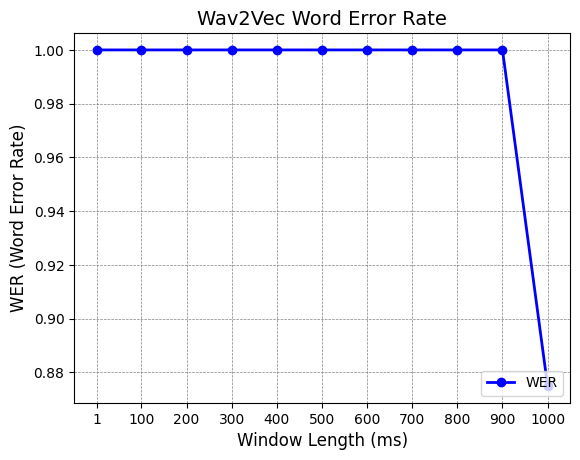

In [28]:
import matplotlib.pyplot as plt

def create_graph(x_values, y_values):
    # Customize the plot
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', linewidth=2)
    plt.xlabel("Window Length (ms)", fontsize=12)
    plt.ylabel('WER (Word Error Rate)', fontsize=12)
    plt.title("Wav2Vec Word Error Rate", fontsize=14)
    plt.grid(True)

    # Customize the x-axis tick values and labels
    plt.xticks(x_values, fontsize=10)

    # Add a background grid
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Add a legend
    plt.legend(['WER'], loc='lower right')




    # Adjust the plot margins
    plt.margins(0.05)

    # Show the plot
    plt.show()

# Example data
x_data = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_data = error_list_3

# Call the function to create the graph
create_graph(x_data, y_data)


My Manipulation (frequency shift)

In [29]:
#Shifting to higher frequency
import numpy as np
from scipy.io import wavfile
from scipy.fft import rfft, irfft


# Normalize the audio data
signal = signal / np.max(np.abs(signal))

# Compute the FFT
transformed_audio = rfft(signal)

# Perform the frequency shift
shift_frequency_list =[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Frequency shift amount (Hz)


# Shift the frequencies
shift_list = []
for shift_frequency in shift_frequency_list:
  shift_indices = np.round(shift_frequency * len(transformed_audio) / sr).astype(int)
  transformed_audio_shifted = np.roll(transformed_audio, shift_indices)
  shift_list.append(transformed_audio_shifted)

# Apply the inverse FFT
shift_data_list = []
for transformed_audio in shift_list:
  shifted_audio_data = irfft(transformed_audio)
  shift_data_list. append(shifted_audio_data)
  ipd.display(Audio(data=shifted_audio_data, rate=sr))


In [30]:
#Feeding manipulations to Wav2Vec2.0
# Create an empty list to store the resulting text after feeding shifted data to Wav2Vec2.0
text5_list = []

# Iterate over each data in shift_data_list
for data in shift_data_list:

    # Tokenize the shifted data using the tokenizer and convert it to PyTorch tensors
    input_values = tokenizer(data, return_tensors="pt").input_values

    # Pass the input values through the Wav2Vec2.0 model to get the logits
    logits = model(input_values).logits

    # Find the predicted token ids by taking the argmax along the last dimension of the logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Decode the predicted token ids into text using the tokenizer and extract the first (and only) sequence
    text_5 = tokenizer.batch_decode(predicted_ids)[0]

    # Append the resulting text to the text5_list
    text5_list.append(text_5)

    # Print the resulting text
    print(text_5)

CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCARD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCARD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCARN RETURNED TO ITS PLACE AMIDST THE TENTS
KANCAR RETURNED TO ITS PLACE AMIDST THE TENTS


In [31]:
# Set the reference text for comparison
reference = text

# Create an empty list to store the WER for each manipulation
error_list_4 = []

# Iterate over each hypothesis text in text5_list
for hypothesis_4 in text5_list:

    # Calculate the word error rate (WER) between the reference and the hypothesis text
    error_4 = wer(reference, hypothesis_4)

    # Print the calculated WER
    print(error_4)

    # Append the WER to the error_list_4
    error_list_4.append(error_4)

    # Print the current contents of the error_list_4
    print(error_list_4)


0.0
[0.0]
0.0
[0.0, 0.0]
0.0
[0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.125
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125]
0.125
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.125]
0.125
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.125, 0.125]
0.125
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.125, 0.125, 0.125]


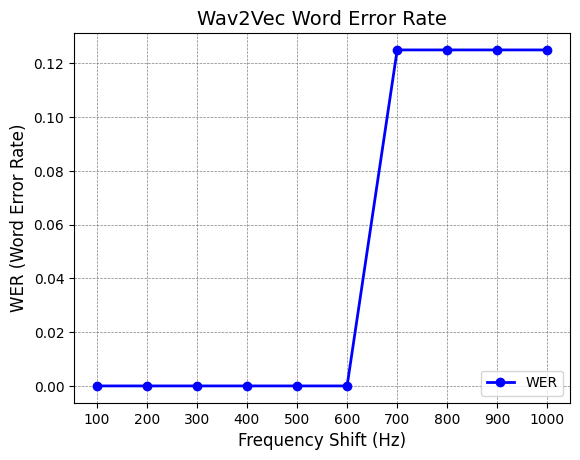

In [32]:
import matplotlib.pyplot as plt

def create_graph(x_values, y_values):
    # Customize the plot
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', linewidth=2)
    plt.xlabel("Frequency Shift (Hz)", fontsize=12)
    plt.ylabel('WER (Word Error Rate)', fontsize=12)
    plt.title("Wav2Vec Word Error Rate", fontsize=14)
    plt.grid(True)

    # Customize the x-axis tick values and labels
    plt.xticks(x_values, fontsize=10)

    # Add a background grid
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Add a legend
    plt.legend(['WER'], loc='lower right')




    # Adjust the plot margins
    plt.margins(0.05)

    # Show the plot
    plt.show()

# Example data
x_data = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_data = error_list_4

# Call the function to create the graph
create_graph(x_data, y_data)


In [33]:
import numpy as np
from scipy.io import wavfile
from scipy.fft import rfft, irfft

# Normalize the audio data
signal = signal / np.max(np.abs(signal))

# Perform the frequency shift
shift_frequency = [-100, -200, -300, -400, -500, -600, -700, -800, -900, -1000]  # Frequency shift amount (Hz)

# Compute the FFT
transformed_audio = rfft(signal)

# Shift the frequencies
shifted_list = []
for shifted_frequency in shift_frequency:
  shift_indices2 = np.round(shifted_frequency * len(transformed_audio) / sr).astype(int)
  transformed_audio_shifted2 = np.roll(transformed_audio, shift_indices2)
  shifted_list.append(transformed_audio_shifted2)

# Apply the inverse FFT
shifted_data_list =[]
for transformed_audio2 in shifted_list:
  shifted_audio_data2 = irfft(transformed_audio2)
  shifted_data_list.append(shifted_audio_data2)
  ipd.display(Audio(data=shifted_audio_data2, rate=sr))

In [34]:
# Create an empty list to store the resulting text after feeding shifted data to Wav2Vec2.0
text6_list = []

# Iterate over each data2 in shifted_data_list
for data2 in shifted_data_list:

    # Tokenize the shifted data2 using the tokenizer and convert it to PyTorch tensors
    input_values = tokenizer(data2, return_tensors="pt").input_values

    # Pass the input values through the Wav2Vec2.0 model to get the logits
    logits = model(input_values).logits

    # Find the predicted token ids by taking the argmax along the last dimension of the logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Decode the predicted token ids into text using the tokenizer and extract the first (and only) sequence
    text_6 = tokenizer.batch_decode(predicted_ids)[0]

    # Append the resulting text to the text6_list
    text6_list.append(text_6)

    # Print the resulting text
    print(text_6)


CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
CONICORD RETURNED TO ITS PLACE AMITS THE TENTS
CONCON RETURNED TO ITS PLACE AMITS THE TENTS
CORRINCLLY ON WHAT TURN TO ITS PLACE IN AMIDST THE TURNS
CARECALY O MATURN T WHICH PASON AMIDST THE TUDES
CARENTLY ON A TRUNK WHICH CANS NEITS THE TUBES
CERECLY O A TRONTWITCH GAINST EM ITS THE TURNS
CAR CLE OF A TROMPAT GAINST AMIDST THE TANTS


In [35]:
# Set the reference text for comparison
reference = text

# Create an empty list to store the WER for each manipulation
error_list_5 = []

# Iterate over each hypothesis text in text6_list
for hypothesis_5 in text6_list:

    # Calculate the word error rate (WER) between the reference and the hypothesis text
    error_5 = wer(reference, hypothesis_5)

    # Print the calculated WER
    print(error_5)

    # Append the WER to the error_list_5
    error_list_5.append(error_5)

    # Print the current contents of the error_list_5
    print(error_list_5)


0.0
[0.0]
0.0
[0.0, 0.0]
0.0
[0.0, 0.0, 0.0]
0.25
[0.0, 0.0, 0.0, 0.25]
0.25
[0.0, 0.0, 0.0, 0.25, 0.25]
0.75
[0.0, 0.0, 0.0, 0.25, 0.25, 0.75]
0.875
[0.0, 0.0, 0.0, 0.25, 0.25, 0.75, 0.875]
1.0
[0.0, 0.0, 0.0, 0.25, 0.25, 0.75, 0.875, 1.0]
1.0
[0.0, 0.0, 0.0, 0.25, 0.25, 0.75, 0.875, 1.0, 1.0]
0.875
[0.0, 0.0, 0.0, 0.25, 0.25, 0.75, 0.875, 1.0, 1.0, 0.875]


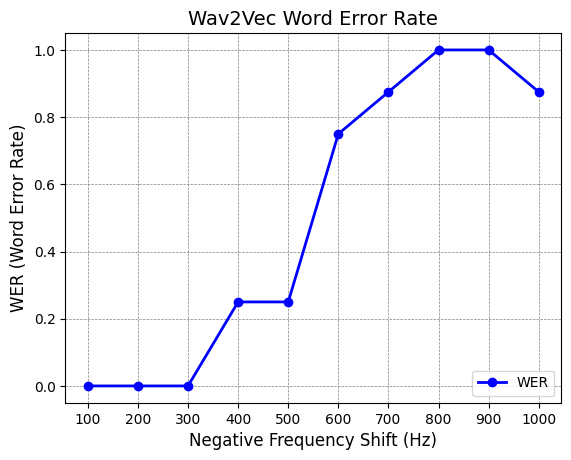

In [36]:
import matplotlib.pyplot as plt

def create_graph(x_values, y_values):
    # Customize the plot
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', linewidth=2)
    plt.xlabel("Negative Frequency Shift (Hz)", fontsize=12)
    plt.ylabel('WER (Word Error Rate)', fontsize=12)
    plt.title("Wav2Vec Word Error Rate", fontsize=14)
    plt.grid(True)

    # Customize the x-axis tick values and labels
    plt.xticks(x_values, fontsize=10)

    # Add a background grid
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Add a legend
    plt.legend(['WER'], loc='lower right')




    # Adjust the plot margins
    plt.margins(0.05)

    # Show the plot
    plt.show()

# Example data
x_data = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_data = error_list_5

# Call the function to create the graph
create_graph(x_data, y_data)

Final Repackaging

In [37]:
#Summing list repacking of 10 audios

import numpy as np

# Declaring initial list of list
List_rp = np.array([[1.0, 1.125, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 0.875, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
[0.9767441860465116, 1.0465116279069768, 1.0, 1.0, 0.9767441860465116, 1.0, 0.8837209302325582, 0.8837209302325582, 0.9767441860465116, 0.8837209302325582, 0.9767441860465116, 0.9069767441860465, 0.9069767441860465, 1.0, 0.9767441860465116, 0.9302325581395349],
[1.0, 1.0, 1.2727272727272727, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 0.9841269841269841, 0.9682539682539683, 0.9682539682539683, 0.9523809523809523, 0.9365079365079365, 0.9206349206349206, 0.9682539682539683, 0.9841269841269841, 0.9523809523809523, 0.9523809523809523, 0.9682539682539683, 0.9365079365079365, 0.9206349206349206],
[1.2903225806451613, 1.032258064516129, 0.967741935483871, 1.0, 0.9354838709677419, 0.967741935483871, 0.967741935483871, 0.9354838709677419, 1.0, 0.9354838709677419, 1.0, 0.967741935483871, 1.0, 1.0, 1.0, 0.9032258064516129],
[1.5454545454545454, 1.2727272727272727, 1.3636363636363635, 1.1818181818181819, 1.0303030303030303, 0.9696969696969697, 0.7272727272727273, 0.7878787878787878, 0.7272727272727273, 0.8181818181818182, 0.8484848484848485, 0.7575757575757576, 0.7575757575757576, 0.6060606060606061, 0.6666666666666666, 0.42424242424242425],
[1.0588235294117647, 2.411764705882353, 2.0588235294117645, 1.3529411764705883, 0.9411764705882353, 0.8235294117647058, 0.5882352941176471, 0.7647058823529411, 0.5882352941176471, 0.8823529411764706, 0.9411764705882353, 0.8235294117647058, 0.9411764705882353, 0.8823529411764706, 0.7058823529411765, 0.8823529411764706],
[1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 0.6666666666666666, 0.8888888888888888, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.8888888888888888, 0.6666666666666666, 0.8888888888888888],
[1.0, 2.272727272727273, 2.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 0.8181818181818182, 0.6363636363636364, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.9090909090909091, 0.7272727272727273, 0.9090909090909091],
[0.9583333333333334, 0.9166666666666666, 0.9166666666666666, 1.4583333333333333, 1.0, 0.8333333333333334, 0.875, 0.8333333333333334, 0.875, 0.875, 0.8333333333333334, 0.75, 0.875, 0.8333333333333334, 0.7916666666666666, 0.5]])

# Using numpy sum
res_rp = np.sum(List_rp, 0)

# printing result
print("final list - ", str(res_rp))

final list -  [10.82967817 13.07765561 12.46848466 10.85221968  9.63605244  9.31255562
  8.86935184  8.90551963  8.44773561  8.76324605  9.06871431  8.64305329
  9.02906952  9.08798065  8.4714072   8.35866845]


In [38]:
# Define a list of floating-point numbers
myList_rp = [10.82967817, 13.07765561, 12.46848466, 10.85221968, 9.63605244, 9.31255562, 8.86935184, 8.90551963, 8.44773561, 8.76324605, 9.06871431, 8.64305329, 9.02906952, 9.08798065, 8.4714072, 8.35866845]

# Define an integer value
myInt = 10

# Create a new list by dividing each element of myList_rp by myInt
newList_rp = [x / myInt for x in myList_rp]

# Print the new list
print(newList_rp)


[1.0829678169999999, 1.307765561, 1.2468484659999999, 1.085221968, 0.963605244, 0.9312555619999999, 0.886935184, 0.8905519630000001, 0.844773561, 0.876324605, 0.9068714310000001, 0.8643053289999999, 0.902906952, 0.908798065, 0.84714072, 0.835866845]


In [39]:
#Creating the final visualisation
import plotly.express as px

def create_graph(x_values, y_values):
    # Create the plot using Plotly Express
    fig = px.line(x=x_values, y=y_values, markers=True)

    # Customize the plot
    fig.update_layout(
        xaxis_title="Audio:Silence Ratio",
        yaxis_title="WER (Word Error Rate)",
        title="Wav2Vec Word Error Rate",
        legend_title="",
        showlegend=True,
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.5),
        margin=dict(l=50, r=50, t=50, b=50),
    )

    # Show the plot
    fig.show()

# Example data
x_data = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
y_data = [1.0829678169999999, 1.307765561, 1.2468484659999999, 1.085221968, 0.963605244, 0.9312555619999999, 0.886935184, 0.8905519630000001, 0.844773561, 0.876324605, 0.9068714310000001, 0.8643053289999999, 0.902906952, 0.908798065, 0.84714072, 0.835866845]

# Call the function to create the graph
create_graph(x_data, y_data)


Final Masking

In [40]:
List_mask = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.09302325581395349, 0.0, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.09302325581395349, 0.09302325581395349, 0.06976744186046512, 0.09302325581395349, 0.023255813953488372, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.14285714285714285, 0.047619047619047616, 0.07936507936507936, 0.047619047619047616, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.19047619047619047, 0.07936507936507936, 0.1111111111111111, 0.047619047619047616],
[0.03225806451612903, 0.03225806451612903, 0.0, 0.0, 0.03225806451612903, 0.0, 0.03225806451612903, 0.03225806451612903, 0.03225806451612903, 0.03225806451612903, 0.03225806451612903],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.030303030303030304, 0.06060606060606061, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.09090909090909091, 0.09090909090909091, 0.0, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0],
[0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.0, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.0, 0.0, 0.041666666666666664]])

# Using numpy sum
res_mask = np.sum(List_mask, 0)

# printing result
print("final list - ", str(res_mask))

final list -  [0.40071422 0.21245287 0.16754337 0.18503977 0.35420259 0.39875919
 0.46132028 0.33416836 0.2046464  0.16662499 0.12154378]


In [41]:
# Define a list of floating-point numbers
myList_mask = [0.40071422, 0.21245287, 0.16754337, 0.18503977, 0.35420259, 0.39875919, 0.46132028, 0.33416836, 0.2046464, 0.16662499, 0.12154378]

# Define an integer value
myInt = 10

# Create a new list by dividing each element of myList_mask by myInt
newList_mask = [x / myInt for x in myList_mask]

# Print the new list
print(newList_mask)

[0.040071422, 0.021245286999999998, 0.016754337, 0.018503976999999998, 0.035420258999999996, 0.039875918999999996, 0.046132028000000005, 0.033416836, 0.02046464, 0.016662499, 0.012154378]


In [42]:
#Final Visualisation for masking
import plotly.express as px

def create_graph(x_values, y_values):
    # Create the plot using Plotly Express
    fig = px.line(x=x_values, y=y_values, markers=True)

    # Customize the plot
    fig.update_layout(
        xaxis_title="Window Length (ms)",
        yaxis_title="WER (Word Error Rate)",
        title="Wav2Vec Word Error Rate",
        legend_title="",
        showlegend=True,
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.5),
        margin=dict(l=50, r=50, t=50, b=50),
    )

    # Show the plot
    fig.show()

# Example data
x_data = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_data = [0.040071422, 0.021245286999999998, 0.016754337, 0.018503976999999998, 0.035420258999999996, 0.039875918999999996, 0.046132028000000005, 0.033416836, 0.02046464, 0.016662499, 0.012154378]

# Call the function to create the graph
create_graph(x_data, y_data)



Final Silencing

In [43]:
#Summing list repacking of 10 audios

import numpy as np

# Declaring initial list of list
List_sil = np.array([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7674418604651163, 0.8837209302325582, 0.6511627906976745],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7272727272727273, 0.9090909090909091, 0.5454545454545454],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7936507936507936, 0.8571428571428571, 0.5555555555555556],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9032258064516129, 0.8387096774193549, 0.7096774193548387],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3939393939393939, 0.6060606060606061, 0.36363636363636365],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411764705882353, 0.23529411764705882, 0.5294117647058824, 0.29411764705882354],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4444444444444444, 1.0, 0.5555555555555556],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8181818181818182, 0.7272727272727273, 0.7272727272727273],
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7083333333333334, 0.7083333333333334, 0.5833333333333334]])

# Using numpy sum
res_sil = np.sum(List_sil, 0)

# printing result
print("final list - ", str(res_sil))

final list -  [10.         10.         10.         10.         10.         10.
 10.          9.94117647  6.7917843   8.05974281  5.86076594]


In [44]:
# Define a list of floating-point numbers
myList_sil = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.94117647, 6.7917843, 8.05974281, 5.86076594]

# Define an integer value
myInt = 10

# Create a new list by dividing each element of myList_sil by myInt
newList_sil = [x / myInt for x in myList_sil]

# Print the new list
print(newList_sil)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994117647, 0.67917843, 0.8059742809999999, 0.586076594]


In [45]:
#Final Visualisation for silencing
import plotly.express as px

def create_graph(x_values, y_values):
    # Create the plot using Plotly Express
    fig = px.line(x=x_values, y=y_values, markers=True)

    # Customize the plot
    fig.update_layout(
        xaxis_title="Window Length (ms)",
        yaxis_title="WER (Word Error Rate)",
        title="Wav2Vec Word Error Rate",
        legend_title="",
        showlegend=True,
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.5),
        margin=dict(l=50, r=50, t=50, b=50),
    )

    # Show the plot
    fig.show()

# Example data
x_data = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_data = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994117647, 0.67917843, 0.8059742809999999, 0.586076594]


# Call the function to create the graph
create_graph(x_data, y_data)


Final Frequency Up

In [46]:
List_fsu = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.125, 0.125, 0.125],
[0.0, 0.0, 0.023255813953488372, 0.023255813953488372, 0.0, 0.0, 0.023255813953488372, 0.023255813953488372, 0.06976744186046512, 0.09302325581395349],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.09090909090909091],
[0.047619047619047616, 0.06349206349206349, 0.015873015873015872, 0.06349206349206349, 0.047619047619047616, 0.047619047619047616, 0.06349206349206349, 0.06349206349206349, 0.09523809523809523, 0.06349206349206349],
[0.0, 0.0, 0.03225806451612903, 0.03225806451612903, 0.03225806451612903, 0.03225806451612903, 0.06451612903225806, 0.06451612903225806, 0.0967741935483871, 0.12903225806451613],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.030303030303030304, 0.0, 0.09090909090909091, 0.09090909090909091],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17647058823529413, 0.5294117647058824],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.36363636363636365],
[0.0, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.041666666666666664]])

# Using numpy sum
res_fsu = np.sum(List_fsu, 0)

# printing result
print("final list - ", str(res_fsu))

final list -  [0.04761905 0.10515873 0.11305356 0.16067261 0.12154378 0.32356398
 0.45934481 0.42904178 0.89784628 1.63819167]


In [47]:
# Define a list of floating-point numbers
myList_fsu = [0.04761905, 0.10515873, 0.11305356, 0.16067261, 0.12154378, 0.32356398, 0.45934481, 0.42904178, 0.89784628, 1.63819167]

# Define an integer value
myInt = 10

# Create a new list by dividing each element of myList_sil by myInt
newList_fsu = [x / myInt for x in myList_fsu]

# Print the new list
print(newList_fsu)

[0.004761905, 0.010515873, 0.011305355999999999, 0.016067261, 0.012154378, 0.032356397999999995, 0.045934481, 0.042904178, 0.089784628, 0.16381916700000002]


In [52]:
# Final Visualsiation Frequency Up

import plotly.express as px

def create_graph(x_values, y_values):
    ## Create the plot using Plotly Express
    fig = px.line(x=x_values, y=y_values, markers=True)

    ## Customize the plot
    fig.update_layout(
        xaxis_title="Frequency Shift (Hz)",
        yaxis_title="WER (Word Error Rate)",
        title="Wav2Vec Word Error Rate",
        legend_title="",
        showlegend=True,
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.5, range=[0, 0.8]),  # Set y-axis range to [0, 0.8]
        margin=dict(l=50, r=50, t=50, b=50),
    )

    ## Show the plot
    fig.show()

## Example data
x_data = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_data = [0.004761905, 0.010515873, 0.011305355999999999, 0.016067261, 0.012154378, 0.032356397999999995, 0.045934481, 0.042904178, 0.089784628, 0.16381916700000002]

## Call the function to create the graph
create_graph(x_data, y_data)



Final Frequency down

In [49]:
List_fsd = np.array([[0.0, 0.0, 0.0, 0.25, 0.25, 0.75, 0.875, 1.0, 1.0, 0.875],
[0.0, 0.0, 0.0, 0.023255813953488372, 0.046511627906976744, 0.046511627906976744, 0.13953488372093023, 0.5813953488372093, 0.813953488372093, 0.8604651162790697],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8181818181818182, 1.2727272727272727, 1.4545454545454546, 1.1818181818181819],
[0.047619047619047616, 0.06349206349206349, 0.015873015873015872, 0.06349206349206349, 0.047619047619047616, 0.047619047619047616, 0.06349206349206349, 0.06349206349206349, 0.09523809523809523, 0.06349206349206349],
[0.0, 0.03225806451612903, 0.0, 0.0, 0.03225806451612903, 0.25806451612903225, 0.7096774193548387, 0.8709677419354839, 0.967741935483871, 0.967741935483871],
[0.0, 0.0, 0.06060606060606061, 0.030303030303030304, 0.030303030303030304, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727, 0.6363636363636364, 0.9090909090909091],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.11764705882352941, 0.29411764705882354, 0.5294117647058824, 0.7058823529411765, 0.8235294117647058],
[0.0, 0.0, 0.0, 0.1111111111111111, 0.4444444444444444, 0.4444444444444444, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888],
[0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.36363636363636365, 0.6363636363636364, 0.8181818181818182, 0.9090909090909091, 0.9090909090909091],
[0.0, 0.125, 0.041666666666666664, 0.08333333333333333, 0.16666666666666666, 0.2916666666666667, 0.75, 0.75, 0.875, 0.75]])

# Using numpy sum
res_fsd = np.sum(List_fsd, 0)

# printing result
print("final list - ", str(res_fsd))

final list -  [0.04761905 0.22075013 0.11814574 0.56149535 1.10871197 2.41049882
 5.24596343 6.93668106 8.34670476 8.22911742]


In [50]:
# Define a list of floating-point numbers
myList_fsd = [0.04761905, 0.22075013, 0.11814574, 0.56149535, 1.10871197, 2.41049882, 5.24596343, 6.93668106, 8.34670476, 8.22911742]

# Define an integer value
myInt = 10

# Create a new list by dividing each element of myList_sil by myInt
newList_fsd = [x / myInt for x in myList_fsd]

# Print the new list
print(newList_fsd)

[0.004761905, 0.022075012999999997, 0.011814574, 0.056149534999999993, 0.110871197, 0.241049882, 0.524596343, 0.693668106, 0.834670476, 0.822911742]


In [51]:
# Final Visualsation Frequency Down

import plotly.express as px

def create_graph(x_values, y_values):
    # Create the plot using Plotly Express
    fig = px.line(x=x_values, y=y_values, markers=True)

    # Customize the plot
    fig.update_layout(
        xaxis_title="Negative Frequency Shift(Hz)",
        yaxis_title="WER (Word Error Rate)",
        title="Wav2Vec Word Error Rate",
        legend_title="",
        showlegend=True,
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=0.5),
        margin=dict(l=50, r=50, t=50, b=50),
    )

    # Show the plot
    fig.show()

# Example data
x_data = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
y_data = [0.004761905, 0.022075012999999997, 0.011814574, 0.056149534999999993, 0.110871197, 0.241049882, 0.524596343, 0.693668106, 0.834670476, 0.822911742]


# Call the function to create the graph
create_graph(x_data, y_data)
